# Test script for multi-decade optimisation

In [1]:
import sys
import os
sys.path = [os.pardir] + sys.path
import pypsa
print(pypsa.__file__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import yaml
plt.style.use('bmh')

../pypsa/__init__.py


create pypsa network

In [2]:
n = pypsa.Network()

snapshots are now a pandas MultiIndex (first level = investment_period (default: "first"), second level = snapshot)

In [3]:
n.snapshots


MultiIndex([('first', 'now')],
           names=['investment_period', 'snapshot'])

there is a new component "investment_period", representing the timesteps at which new investments are made. Analog to snapshots there are investment_period_weightings, but those are split into "energy_weightings" (e.g. used for CO2 emissions) and "investment_weightings" (e.g. used for cost weightings)

In [4]:
n.investment_periods

Index([('first', 'now')], dtype='object')

In [5]:
n.investment_period_weightings

,investment_weighting,energy_weighting
"(first, now)",1.0,1.0


## How to set snapshots and investment periods 
First set some parameters

In [6]:
# years of investment
years = [2020, 2030, 2040, 2050]
investment = pd.DatetimeIndex(['{}-01-01 00:00'.format(year) for year in years])

# temporal resolution
freq = "2190"
# snapshots (format -> DatetimeIndex)
snapshots = pd.DatetimeIndex([])
snapshots = snapshots.append([(pd.date_range(start ='{}-01-01 00:00'.format(year),
                                               freq ='{}H'.format(freq),
                                               periods=8760/float(freq))) for year in years])
snapshots

DatetimeIndex(['2020-01-01 00:00:00', '2020-04-01 06:00:00',
               '2020-07-01 12:00:00', '2020-09-30 18:00:00',
               '2030-01-01 00:00:00', '2030-04-02 06:00:00',
               '2030-07-02 12:00:00', '2030-10-01 18:00:00',
               '2040-01-01 00:00:00', '2040-04-01 06:00:00',
               '2040-07-01 12:00:00', '2040-09-30 18:00:00',
               '2050-01-01 00:00:00', '2050-04-02 06:00:00',
               '2050-07-02 12:00:00', '2050-10-01 18:00:00'],
              dtype='datetime64[ns]', freq=None)

you can **set the snapshots**:  <br>   
(a) either in the way you are used to as pandas DatetimeIndex, investment_period will than be default value ("first")

In [7]:
n.set_snapshots(snapshots)
n.snapshots

MultiIndex([('first', '2020-01-01 00:00:00'),
            ('first', '2020-04-01 06:00:00'),
            ('first', '2020-07-01 12:00:00'),
            ('first', '2020-09-30 18:00:00'),
            ('first', '2030-01-01 00:00:00'),
            ('first', '2030-04-02 06:00:00'),
            ('first', '2030-07-02 12:00:00'),
            ('first', '2030-10-01 18:00:00'),
            ('first', '2040-01-01 00:00:00'),
            ('first', '2040-04-01 06:00:00'),
            ('first', '2040-07-01 12:00:00'),
            ('first', '2040-09-30 18:00:00'),
            ('first', '2050-01-01 00:00:00'),
            ('first', '2050-04-02 06:00:00'),
            ('first', '2050-07-02 12:00:00'),
            ('first', '2050-10-01 18:00:00')],
           names=['investment_period', 'snapshots'])

(b) or as a pandas MultiIndex, this will also change the investment_periods to the first level of the pd.MultiIndex

In [8]:
investment_helper = investment.union(pd.Index([snapshots[-1] + pd.Timedelta(days=1)]))
map_dict = {investment[period] :
            snapshots[(snapshots>=investment_helper[period]) &
                      (snapshots<investment_helper[period+1])]
            for period in range(len(investment))}

multiindex = pd.MultiIndex.from_tuples([(name, l) for name, levels in
                                        map_dict.items() for l in levels])
multiindex

MultiIndex([('2020-01-01', '2020-01-01 00:00:00'),
            ('2020-01-01', '2020-04-01 06:00:00'),
            ('2020-01-01', '2020-07-01 12:00:00'),
            ('2020-01-01', '2020-09-30 18:00:00'),
            ('2030-01-01', '2030-01-01 00:00:00'),
            ('2030-01-01', '2030-04-02 06:00:00'),
            ('2030-01-01', '2030-07-02 12:00:00'),
            ('2030-01-01', '2030-10-01 18:00:00'),
            ('2040-01-01', '2040-01-01 00:00:00'),
            ('2040-01-01', '2040-04-01 06:00:00'),
            ('2040-01-01', '2040-07-01 12:00:00'),
            ('2040-01-01', '2040-09-30 18:00:00'),
            ('2050-01-01', '2050-01-01 00:00:00'),
            ('2050-01-01', '2050-04-02 06:00:00'),
            ('2050-01-01', '2050-07-02 12:00:00'),
            ('2050-01-01', '2050-10-01 18:00:00')],
           )

In [9]:
n.set_snapshots(multiindex)
n.snapshots

MultiIndex([('2020-01-01', '2020-01-01 00:00:00'),
            ('2020-01-01', '2020-04-01 06:00:00'),
            ('2020-01-01', '2020-07-01 12:00:00'),
            ('2020-01-01', '2020-09-30 18:00:00'),
            ('2030-01-01', '2030-01-01 00:00:00'),
            ('2030-01-01', '2030-04-02 06:00:00'),
            ('2030-01-01', '2030-07-02 12:00:00'),
            ('2030-01-01', '2030-10-01 18:00:00'),
            ('2040-01-01', '2040-01-01 00:00:00'),
            ('2040-01-01', '2040-04-01 06:00:00'),
            ('2040-01-01', '2040-07-01 12:00:00'),
            ('2040-01-01', '2040-09-30 18:00:00'),
            ('2050-01-01', '2050-01-01 00:00:00'),
            ('2050-01-01', '2050-04-02 06:00:00'),
            ('2050-01-01', '2050-07-02 12:00:00'),
            ('2050-01-01', '2050-10-01 18:00:00')],
           )

In [10]:
n.investment_periods

DatetimeIndex(['2020-01-01', '2030-01-01', '2040-01-01', '2050-01-01'], dtype='datetime64[ns]', freq=None)

(c) you can also **set the investment_periods** analog to snapshots with a **list/single Index** or with a **pd.MultiIndex**, both ways change the snapshots as well, e.g.

In [11]:
n = pypsa.Network()
# set investmet periods with list of strings
n.set_investment_periods(["first", "second"])
n.investment_periods

['first', 'second']

In [12]:
n.snapshots

MultiIndex([( 'first', 'now'),
            ('second', 'now')],
           names=[None, 'snapshot'])

In [13]:
# set investment periods with multiindex
n.set_investment_periods(multiindex)
n.investment_periods

DatetimeIndex(['2020-01-01', '2030-01-01', '2040-01-01', '2050-01-01'], dtype='datetime64[ns]', freq=None)

In [14]:
n.snapshots

MultiIndex([('2020-01-01', '2020-01-01 00:00:00'),
            ('2020-01-01', '2020-04-01 06:00:00'),
            ('2020-01-01', '2020-07-01 12:00:00'),
            ('2020-01-01', '2020-09-30 18:00:00'),
            ('2030-01-01', '2030-01-01 00:00:00'),
            ('2030-01-01', '2030-04-02 06:00:00'),
            ('2030-01-01', '2030-07-02 12:00:00'),
            ('2030-01-01', '2030-10-01 18:00:00'),
            ('2040-01-01', '2040-01-01 00:00:00'),
            ('2040-01-01', '2040-04-01 06:00:00'),
            ('2040-01-01', '2040-07-01 12:00:00'),
            ('2040-01-01', '2040-09-30 18:00:00'),
            ('2050-01-01', '2050-01-01 00:00:00'),
            ('2050-01-01', '2050-04-02 06:00:00'),
            ('2050-01-01', '2050-07-02 12:00:00'),
            ('2050-01-01', '2050-10-01 18:00:00')],
           )

In this example, we can set the **investment_period_weightings** for the **energy_weightings** to the difference between the years. The energy weightings are used to calculate the lifetime (if an assets is still active), as well as to weight the CO2 emissions. The **investment_weightings** weight the costs of an investment_period, we can include e.g. social discount rate r=1% here. One could choose the weighting of the last year of the optimisation also to a higher value to weight costs and emission in this period more strongly.

In [15]:
def get_social_discount(t, r):
    return (1/(1+r)**t)

def get_investment_weighting(energy_weighting, r):
    end = energy_weighting.cumsum()
    start = energy_weighting.cumsum().shift().fillna(0)
    return pd.concat([start,end], axis=1).apply(lambda x: sum([get_social_discount(t,r)
                                                               for t in range(int(x[0]), int(x[1]))]),
                                                axis=1)

In [16]:
r = 0.01
# set energy weighting -> last year is weighted by 1
n.investment_period_weightings.loc[:, "energy_weighting"] = n.investment_period_weightings.index.year.to_series().diff().shift(-1).fillna(1).values

# set investment_weighting
n.investment_period_weightings.loc[:, "investment_weighting"] = get_investment_weighting(n.investment_period_weightings["energy_weighting"], r)
n.investment_period_weightings

,investment_weighting,energy_weighting
2020-01-01,9.566018,10.0
2030-01-01,8.659991,10.0
2040-01-01,7.839777,10.0
2050-01-01,0.741923,1.0


still **TODO**: split also the snapshot weightings into two groups

In [17]:
n.snapshot_weightings

2020-01-01  2020-01-01 00:00:00    1.0
            2020-04-01 06:00:00    1.0
            2020-07-01 12:00:00    1.0
            2020-09-30 18:00:00    1.0
2030-01-01  2030-01-01 00:00:00    1.0
            2030-04-02 06:00:00    1.0
            2030-07-02 12:00:00    1.0
            2030-10-01 18:00:00    1.0
2040-01-01  2040-01-01 00:00:00    1.0
            2040-04-01 06:00:00    1.0
            2040-07-01 12:00:00    1.0
            2040-09-30 18:00:00    1.0
2050-01-01  2050-01-01 00:00:00    1.0
            2050-04-02 06:00:00    1.0
            2050-07-02 12:00:00    1.0
            2050-10-01 18:00:00    1.0
dtype: float64

# Build small test network

In [18]:
# add three buses
for i in range(3):
    n.add("Bus",
          "bus {}".format(i))

There are 2 new attribute for the components ("Line", "Link", "Generator", Storage",...) <br>
    (1) "**build_year**" : time when the asset is build (=first year of operation) <br>
    (2) "**lifetime**": time of operation (not used to annualise the capital costs) <br>
- If build_year and lifetime is not specified, it is assumed that the asset can operate in all investment_periods. - If only the build_year and no lifetime is specified, it is assumed the the asset can operate from build_year until the end of the optimisation time range
- If the lifetime and no build_year is specified, it is assumed that the assets operates from the first timestep until end of lifetime
- If the investment periods are a pd.DatetimeIndex a build year before the considered time frame is considered. E.g. n.investment_periods = [2020, 2030, 2040] and lifetime of an asset is 15 year, build year is 2010, than the asset can only operate in 2020.

In [19]:
# add three lines in a ring
n.add("Line",
      "line 0->1",
      bus0="bus 0",
      bus1="bus 1",
      x=0.0001,
      s_nom=0,
      #build_year=2030,
      s_nom_extendable=True)

n.add("Line",
      "line 1->2",
      bus0="bus 1",
      bus1="bus 2",
      x=0.0001,
      capital_cost=10,
      build_year=2030,
      s_nom=0,
      s_nom_extendable=True)


n.add("Line",
      "line 2->0",
      bus0="bus 2",
      bus1="bus 0",
      x=0.0001,
      s_nom=0,
      s_nom_extendable=True,
      build_year=2030)

the function **n.determine_network_topology()** takes now as an optional argument the investment_period, be aware that the column values of sub_network are only valid for a certain investment_period. In this example, in the first investment period 2020 "bus 2" would be not connected to "bus 0" and "bus 1"

In [20]:
# works as before -> not considering if the assets are active
n.determine_network_topology()
n.buses.sub_network

bus 0    0
bus 1    0
bus 2    0
Name: sub_network, dtype: object

In [21]:
# determines network topolgy in first investment period (bus 2 isolated)
n.determine_network_topology(n.investment_periods[0])
n.buses.sub_network

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


bus 0    0
bus 1    0
bus 2    1
Name: sub_network, dtype: object

In [22]:
# determines network topology in third investment period (all lines are build)
n.determine_network_topology(n.investment_periods[2])
n.buses.sub_network

bus 0    0
bus 1    0
bus 2    0
Name: sub_network, dtype: object

In [23]:
n.lines.loc["line 2->0", "build_year"] = 2020

In [24]:
# add some generators
p_nom_max = pd.Series((np.random.uniform() for sn in range(len(n.snapshots))),
                  index=n.snapshots, name="generator ext 2020")

# renewable (can operate 2020, 2030)
n.add("Generator","generator ext 0 2020",
       bus="bus 0",
       p_nom=50,
       build_year=2020,
       lifetime=20,
       marginal_cost=2,
       capital_cost=1,
       p_max_pu=p_nom_max,
       carrier="solar",
       p_nom_extendable=True)

# add an expensive generator (can operate in all investment periods)
n.add("Generator",
      "generator fix expensive 2 2020",
      bus="bus 2",
      p_nom=100,
      build_year=2020,
      lifetime=31,
      carrier="lignite",
      marginal_cost=1000,
      capital_cost=10)

# can operate 2040, 2050
n.add("Generator","generator ext 0 2040",
      bus="bus 0",
      p_nom=50,
      build_year=2040,
      lifetime=11,
      marginal_cost=25,
      capital_cost=10,
      carrier="OCGT",
      p_nom_extendable=True)

# can operate in 2040
n.add("Generator",
      "generator fix 1 2040",
      bus="bus 1",
      p_nom=50,
      build_year=2040,
      lifetime=10,
      carrier="CCGT",
      marginal_cost=20,
      capital_cost=1,
      )

In [25]:
# add StorageUnits
n.add("StorageUnit",
      "storageunit cyclic 2030",
      bus="bus 2",
      p_nom=0,
      # marginal_cost=5,
      capital_cost=0.1,
      build_year=2030,
      lifetime=21,
      # efficiency_dispatch=0.9,
      # efficiency_store=0.99,
      cyclic_state_of_charge=True,
      p_nom_extendable=True,
      max_hours=180
      )

n.add("StorageUnit",
      "storageunit noncyclic 2030",
      bus="bus 2",
      p_nom=0,
      # marginal_cost=5,
      capital_cost=0.1,
      build_year=2030,
      lifetime=21,
      # efficiency_dispatch=0.9,
      # efficiency_store=0.99,
      # cyclic_state_of_charge=True,
      p_nom_extendable=True,
      max_hours=180
      )


In [26]:
# add battery store
n.add("Bus",
      "bus 2 battery")
# #
n.add("Store",
      "store 2 battery 2020",
       bus="bus 2 battery",
      e_cyclic=True,
      e_nom_extendable=True,
      build_year=2020,
      lifetime=20,
      capital_cost=2)

n.add("Link",
      "bus2 battery charger",
      bus0= "bus 2" ,
      bus1= "bus 2" + " battery",
      # efficiency=0.8,
      # capital_cost=2,
      p_nom_extendable=True)

n.add("Link",
      "My bus2 battery discharger",
      bus0="bus 2 battery",
      bus1="bus 2",
       efficiency=0.8,
      # marginal_cost=1,
      p_nom_extendable=True)

In [27]:
# add a Load
load_var =  pd.Series((100*np.random.uniform() for sn in range(len(n.snapshots))),
                  index=n.snapshots, name="load")
load_fix = pd.Series([250 for sn in range(len(n.snapshots))],
                  index=n.snapshots, name="load")

#add a load at bus 2
n.add("Load",
      "load 2",
      bus="bus 2",
      p_set=load_fix)

n.add("Load",
      "load 1",
      bus="bus 1",
      p_set=0.3*load_fix)

### Solve and results

Currently, all modifications for multi-decade are only made for **pyomo=False**

In [28]:
n.lopf(snapshots=n.snapshots,solver_name="gurobi",
       pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.74s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Academic license - for non-commercial use only - expires 2021-01-30
Using license file /home/ws/bw0928/gurobi.lic
Read LP format model from file /tmp/pypsa-problem-pvv0tp9o.lp
Reading time = 0.00 seconds
obj: 640 rows, 283 columns, 1403 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 640 rows, 283 columns and 1403 nonzeros
Model fingerprint: 0x0985bf0b
Coefficient statistics:
  Matrix range     [4e-02, 2e+02]
  Objective range  [1e+00, 1e+04]
  Bounds range     [5e+03, 5e+03]
  RHS range        [5e+01, 1e+03]
Presolve removed 470 rows and 139 columns
Presolve time: 0.01s
Presolved: 170 rows, 144 columns, 576 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2021503e+03   3.943750e+03   0.000000e+00      0s
      84    1.8571709e+05   0.000000e+00   0.000000e+00      0s

Solved in 84 iterations and 0.01 seconds
Optimal objective  1.857

INFO:pypsa.linopf:Optimization successful. Objective value: 1.86e+05


('ok', 'optimal')

In [29]:
n.generators[["p_nom_opt", "build_year", "lifetime"]]

attribute,p_nom_opt,build_year,lifetime
generator ext 0 2020,1434.340314,2020.0,20.0
generator fix expensive 2 2020,100.000000,2020.0,31.0
generator ext 0 2040,276.276894,2040.0,11.0
generator fix 1 2040,50.000000,2040.0,10.0


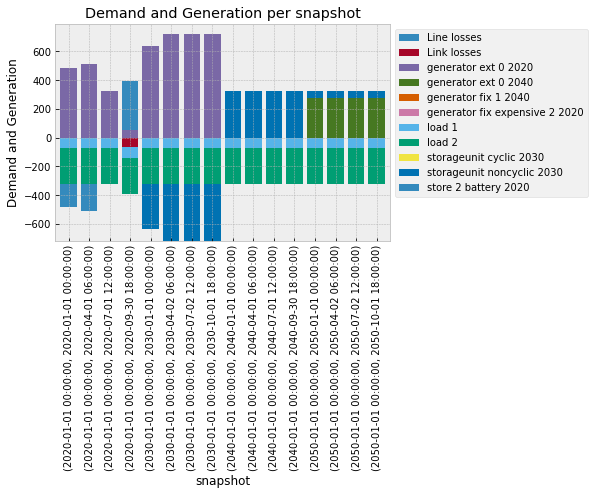

In [30]:
total = pd.concat([n.generators_t.p, n.storage_units_t.p_dispatch,
           -1 * n.storage_units_t.p_store, n.stores_t.p,
           -1 * n.loads_t.p_set,
           -1 * pd.concat([n.links_t.p0, n.links_t.p1], axis=1).sum(axis=1).rename("Link losses"),
           -1 * pd.concat([n.lines_t.p0, n.lines_t.p1], axis=1).sum(axis=1).rename("Line losses")], axis=1)
total = total.groupby(total.columns, axis=1).sum()
total.plot(kind="bar", stacked=True, grid=True, title="Demand and Generation per snapshot", width=0.8)
plt.ylabel("Demand and Generation")
plt.xlabel("snapshot")
plt.legend(bbox_to_anchor=(1,1))

### new constraints for each investment period
1. ) stores and storageunits which are cyclic, have to be cyclic in each investment_period
2. ) all the demand should be covered by the generation in each investment_period

Text(0.5, 0, 'snapshot')

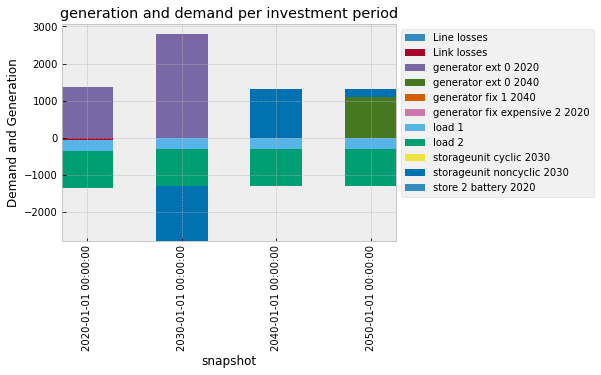

In [31]:
total.groupby(level=0).sum().plot(kind="bar", stacked=True, width=2000, grid=True,
                                  title="generation and demand per investment period").legend(bbox_to_anchor=(1,1))
plt.ylabel("Demand and Generation")
plt.xlabel("snapshot")

In [32]:
total.groupby(level=0).sum().sum(axis=1)

2020-01-01    2.273737e-13
2030-01-01    2.273737e-13
2040-01-01    0.000000e+00
2050-01-01    5.684342e-14
dtype: float64

add a function to get the capacity per investment_period of the active assets

In [33]:
def get_cap_per_investment_period(n, c):
    """
    returns the installed capacities for each investment period and component
    depending on build year and lifetime

    n: pypsa network
    c: pypsa component (e.g. "Generator")
    cap_per_inv: pd.DataFrame(index=investment_period, columns=components)

    """
    df = n.df(c)
    cap_per_inv = pd.DataFrame(np.repeat([df.loc[:,df.columns.str.contains("_nom_opt")].iloc[:,0]],
                                         len(n.investment_periods), axis=0),
                               index=n.investment_periods, columns=df.index)
    # decomissioned set caps to zero
    decomissioned_i = cap_per_inv.apply(lambda x: (x.index.year>df.loc[x.name, ["build_year", "lifetime"]].sum()-1))
    cap_per_inv[decomissioned_i] = 0
    # before build year set caps to zero
    not_build_i = cap_per_inv.apply(lambda x: x.index.year<df.loc[x.name, "build_year"])
    cap_per_inv[not_build_i] = 0

    return cap_per_inv

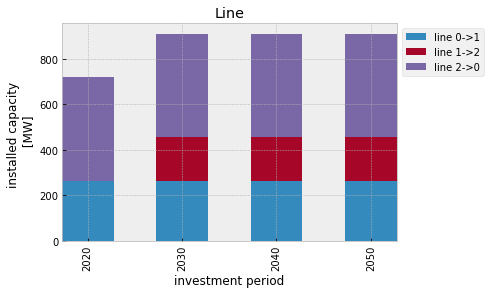

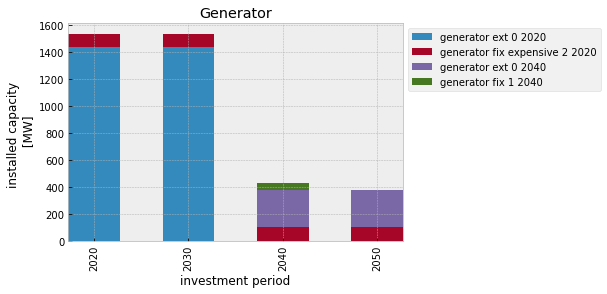

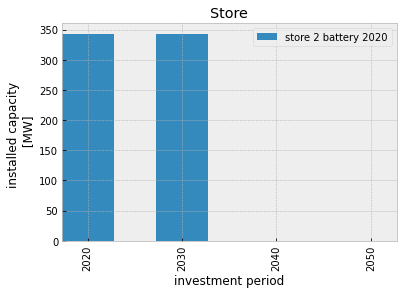

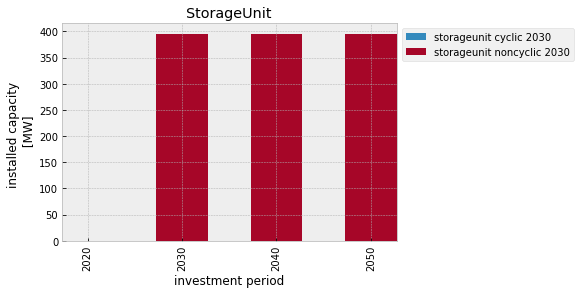

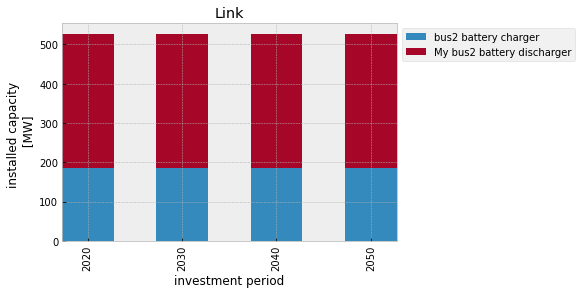

In [34]:
for component in ["Line", "Generator", "Store", "StorageUnit", "Link"]:
    caps = get_cap_per_investment_period(n, component)
    if caps.empty: continue
    ax=caps.plot(kind="bar", stacked=True, title=component, grid=True, width=2000)
    ticklabels = caps.index.year
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.ylabel("installed capacity \n [MW]")
    plt.xlabel("investment period")
    plt.legend(bbox_to_anchor=(1,1))

# Test with PyPSA-Eur network

In [35]:
path_eur = "/home/ws/bw0928/Dokumente/pypsa-eur/"
n = pypsa.Network(path_eur + "networks/elec_s_38_ec_lv1.0_.nc")

set format of snapshots from DatetimeIndex (older pypsa version)
to MultiIndex
INFO:pypsa.io:Imported network elec_s_38_ec_lv1.0_.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


if a pypsa network from current version **without** MultiIndex snapshot is imported, a warning is given and the investment_period is set to default(["first"])

In [36]:
n.snapshots

MultiIndex([('first', '2013-01-01 00:00:00'),
            ('first', '2013-01-01 01:00:00'),
            ('first', '2013-01-01 02:00:00'),
            ('first', '2013-01-01 03:00:00'),
            ('first', '2013-01-01 04:00:00'),
            ('first', '2013-01-01 05:00:00'),
            ('first', '2013-01-01 06:00:00'),
            ('first', '2013-01-01 07:00:00'),
            ('first', '2013-01-01 08:00:00'),
            ('first', '2013-01-01 09:00:00'),
            ...
            ('first', '2013-12-31 14:00:00'),
            ('first', '2013-12-31 15:00:00'),
            ('first', '2013-12-31 16:00:00'),
            ('first', '2013-12-31 17:00:00'),
            ('first', '2013-12-31 18:00:00'),
            ('first', '2013-12-31 19:00:00'),
            ('first', '2013-12-31 20:00:00'),
            ('first', '2013-12-31 21:00:00'),
            ('first', '2013-12-31 22:00:00'),
            ('first', '2013-12-31 23:00:00')],
           names=['investment_period', 'snapshot'], length=8760

For GlobalConstraint of the technical limit at each node, get the p_nom_max

In [37]:
p_nom_max_limit = n.generators.p_nom_max.groupby([n.generators.carrier, n.generators.bus]).sum()

Only consider a few snapshots to speed up the calculations

In [38]:
nhours=876
n.set_snapshots(n.snapshots[::nhours])
n.snapshot_weightings.loc[:] = nhours
n.snapshots

MultiIndex([('first', '2013-01-01 00:00:00'),
            ('first', '2013-02-06 12:00:00'),
            ('first', '2013-03-15 00:00:00'),
            ('first', '2013-04-20 12:00:00'),
            ('first', '2013-05-27 00:00:00'),
            ('first', '2013-07-02 12:00:00'),
            ('first', '2013-08-08 00:00:00'),
            ('first', '2013-09-13 12:00:00'),
            ('first', '2013-10-20 00:00:00'),
            ('first', '2013-11-25 12:00:00')],
           names=['investment_period', 'snapshot'])

Test if network solves without changing to multi-decade investment

In [39]:
n.lopf(snapshots=n.snapshots,solver_name="gurobi",
       pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /tmp/pypsa-problem-ne40i0ac.lp
Reading time = 0.03 seconds
obj: 17191 rows, 8135 columns, 37344 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17191 rows, 8135 columns and 37344 nonzeros
Model fingerprint: 0x1f728975
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e+00, 2e+05]
  Bounds range     [1e-01, 9e+05]
  RHS range        [9e-01, 8e+07]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 11986 rows and 767 columns
Presolve time: 0.03s
Presolved: 5205 rows, 7368 columns, 23826 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.148e+04
 Factor NZ  : 1.251e+05 (roughly 6 MBytes of memory)
 Factor Ops : 3.800e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.97e+10


('ok', 'optimal')

In [40]:
n = pypsa.Network(path_eur + "networks/elec_s_45_ec.nc")
n.set_snapshots(n.snapshots[::nhours])
n.snapshot_weightings.loc[:] = nhours

set format of snapshots from DatetimeIndex (older pypsa version)
to MultiIndex
INFO:pypsa.io:Imported network elec_s_45_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


 create new time-varying data for all investment years

In [41]:
def set_new_sns_invp(n, inv_years):
    """
    set new snapshots (sns) for all time varying componentents and
    investment_periods depending on investment years ('inv_years')

    input:
        n: pypsa.Network()
        inv_years: list of investment periods, e.g. [2020, 2030, 2040]

    """

    for component in n.all_components:
        pnl = n.pnl(component)
        attrs = n.components[component]["attrs"]

        for k,default in attrs.default[attrs.varying].iteritems():
            pnl[k] = pd.concat([(pnl[k].rename(index=lambda x: x.replace(year=year), level=1)
                                       .rename(index=lambda x: n.snapshots.get_level_values(level=1)[0].replace(year=year), level=0))
                                for year in inv_years])

    # set new snapshots + investment period
    investment = [(n.snapshots.get_level_values(level=1).year==year).argmax() for year in inv_years]
    n.snapshot_weightings = pd.concat([(n.snapshot_weightings.rename(index=lambda x: x.replace(year=year), level=1)
                                       .rename(index=lambda x: n.snapshots.get_level_values(level=1)[0].replace(year=year), level=0))
                                for year in inv_years])
    n.set_snapshots(n.snapshot_weightings.index)
    n.set_investment_periods(n.snapshots)

In [42]:
# create new time-varying data for all investment years
set_new_sns_invp(n, years)
n.generators_t.p_max_pu

AL0 0 offwind-ac  AL0 0 onwind  \
investment_period snapshot                                              
2020-01-01        2020-01-01 00:00:00          0.004358      0.002845   
                  2020-02-06 12:00:00          0.561709      0.160803   
                  2020-03-15 00:00:00          0.575210      0.127008   
                  2020-04-20 12:00:00          0.014456      0.010634   
                  2020-05-27 00:00:00          0.004183      0.004082   
                  2020-07-02 12:00:00          0.078149      0.027492   
                  2020-08-08 00:00:00          0.000000      0.000000   
                  2020-09-13 12:00:00          0.072784      0.032807   
                  2020-10-20 00:00:00          0.016132      0.001713   
                  2020-11-25 12:00:00          0.008437      0.001534   
2030-01-01        2030-01-01 00:00:00          0.004358      0.002845   
                  2030-02-06 12:00:00          0.561709      0.160803   
                  2030-03-15 00:00:00          0.575210      0.127008   
                  2030-04-20 12:00:00          0.014456      0.010634   
                  2030-05-27 00:00:00          0.004183      0.004082   
                  2030-07-02 12:00:00          0.078149      0.027492   
                  2030-08-08 00:00:00          0.000000      0.000000   
                  2030-09-13 12:00:00          0.072784      0.032807   
                  2030-10-20 00:00:00          0.016132      0.001713   
                  2030-11-25 12:00:00          0.008437      0.001534   
2040-01-01        2040-01-01 00:00:00          0.004358      0.002845   
                  2040-02-06 12:00:00          0.561709      0.160803   
                  2040-03-15 00:00:00          0.575210      0.127008   
                  2040-04-20 12:00:00          0.014456      0.010634   
                  2040-05-27 00:00:00          0.004183      0.004082   
                  2040-07-02 12:00:00          0.078149      0.027492   
                  2040-08-08 00:00:00          0.000000      0.000000   
                  2040-09-13 12:00:00          0.072784      0.032807   
                  2040-10-20 00:00:00          0.016132      0.001713   
                  2040-11-25 12:00:00          0.008437      0.001534   
2050-01-01        2050-01-01 00:00:00          0.004358      0.002845   
                  2050-02-06 12:00:00          0.561709      0.160803   
                  2050-03-15 00:00:00          0.575210      0.127008   
                  2050-04-20 12:00:00          0.014456      0.010634   
                  2050-05-27 00:00:00          0.004183      0.004082   
                  2050-07-02 12:00:00          0.078149      0.027492   
                  2050-08-08 00:00:00          0.000000      0.000000   
                  2050-09-13 12:00:00          0.072784      0.032807   
                  2050-10-20 00:00:00          0.016132      0.001713   
                  2050-11-25 12:00:00          0.008437      0.001534   

                                       AL0 0 solar  AT0 0 onwind  AT0 0 ror  \
investment_period snapshot                                                    
2020-01-01        2020-01-01 00:00:00     0.000000      0.168526   0.225811   
                  2020-02-06 12:00:00     0.166200      0.022518   0.249863   
                  2020-03-15 00:00:00     0.000000      0.674006   0.309573   
                  2020-04-20 12:00:00     0.445803      0.169048   0.664595   
                  2020-05-27 00:00:00     0.000000      0.372161   0.659858   
                  2020-07-02 12:00:00     0.579321      0.009146   0.669620   
                  2020-08-08 00:00:00     0.000000      0.194994   0.296635   
                  2020-09-13 12:00:00     0.169224      0.134784   0.364038   
                  2020-10-20 00:00:00     0.000000      0.029273   0.305510   
                  2020-11-25 12:00:00     0.094431      0.729895   0.352076   
2030-01-01        2030-0

In [43]:
n.snapshots

MultiIndex([('2020-01-01', '2020-01-01 00:00:00'),
            ('2020-01-01', '2020-02-06 12:00:00'),
            ('2020-01-01', '2020-03-15 00:00:00'),
            ('2020-01-01', '2020-04-20 12:00:00'),
            ('2020-01-01', '2020-05-27 00:00:00'),
            ('2020-01-01', '2020-07-02 12:00:00'),
            ('2020-01-01', '2020-08-08 00:00:00'),
            ('2020-01-01', '2020-09-13 12:00:00'),
            ('2020-01-01', '2020-10-20 00:00:00'),
            ('2020-01-01', '2020-11-25 12:00:00'),
            ('2030-01-01', '2030-01-01 00:00:00'),
            ('2030-01-01', '2030-02-06 12:00:00'),
            ('2030-01-01', '2030-03-15 00:00:00'),
            ('2030-01-01', '2030-04-20 12:00:00'),
            ('2030-01-01', '2030-05-27 00:00:00'),
            ('2030-01-01', '2030-07-02 12:00:00'),
            ('2030-01-01', '2030-08-08 00:00:00'),
            ('2030-01-01', '2030-09-13 12:00:00'),
            ('2030-01-01', '2030-10-20 00:00:00'),
            ('2030-01-01', '203

set investment period weightings

In [44]:
# last year is weighted by 1
n.investment_period_weightings.loc[:, "energy_weighting"] = n.investment_period_weightings.index.year.to_series().diff().shift(-1).fillna(1).values
# set investment_weighting
n.investment_period_weightings.loc[:, "investment_weighting"] = get_investment_weighting(n.investment_period_weightings["energy_weighting"], r)


In [45]:
n.investment_period_weightings

,investment_weighting,energy_weighting
investment_period,,
2020-01-01,9.566018,10.0
2030-01-01,8.659991,10.0
2040-01-01,7.839777,10.0
2050-01-01,0.741923,1.0


### Play around with assumptions: 
1. conventional phase out  <br>
2. renewable generators are build in every investment_period  <br>
3. build years for certain AC Lines or DC Links <br>
4. global constraints <br>
    a. carbon budget  <br>
    b. limit onshore wind and solar capacities at each node for each investment period

1) conventional phase out

In [46]:
# conventional lifetime + build year
conventionals = ["lignite", "coal", "oil", "nuclear", "CCGT", "OCGT"]
gens = n.generators[n.generators.carrier.isin(conventionals)].index
n.generators.loc[gens, "build_year"] = 2013
n.generators.loc[gens, "lifetime"] = 20

2.) renewable generator assumptions (e.g. can be newly build in each investment period, capital costs are decreasing,...)

In [47]:
# renewable
renewables = ["solar", "onwind", "offwind-ac", "offwind-dc"]
gen_names = n.generators[n.generators.carrier.isin(renewables)].index
df = n.generators.loc[gen_names]
p_max_pu = n.generators_t.p_max_pu[gen_names]

In [48]:
# drop old renewable generators   
n.generators.drop(gen_names, inplace=True)
n.generators_t.p_max_pu.drop(gen_names, axis=1, inplace=True)

In [49]:
# add new renewable generator for each investment period
counter = 0
for year in n.investment_periods.year:
    n.madd("Generator",
           df.index,
           suffix=" " + str(year),
           bus=df.bus,
           carrier=df.carrier,
           p_nom_extendable=True,
           p_nom_max=df.p_nom_max,
           build_year=year,
           marginal_cost=df.marginal_cost,
           lifetime=15,
           capital_cost=df.capital_cost * 0.9**counter,
           efficiency=df.efficiency * 1.01**counter,
           p_max_pu=p_max_pu)

    counter += 1

In [50]:
n.generators[(n.generators.carrier=="solar") & (n.generators.bus=="DE0 0")]

,p_nom_max,weight,p_nom,capital_cost,marginal_cost,efficiency,p_nom_extendable,bus,carrier,control,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
name,,,,,,,,,,,,,,,,,,,,,
DE0 0 solar 2020,136629.058716,NaN,0.0,55064.071419,0.01,1.000000,True,DE0 0,solar,PQ,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
DE0 0 solar 2030,136629.058716,NaN,0.0,49557.664278,0.01,1.010000,True,DE0 0,solar,PQ,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
DE0 0 solar 2040,136629.058716,NaN,0.0,44601.897850,0.01,1.020100,True,DE0 0,solar,PQ,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
DE0 0 solar 2050,136629.058716,NaN,0.0,40141.708065,0.01,1.030301,True,DE0 0,solar,PQ,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [51]:
n.generators_t.p_max_pu.loc[:, n.generators_t.p_max_pu.columns.str.contains("DE0 0 solar")]

DE0 0 solar 2020  DE0 0 solar 2030  \
investment_period snapshot                                                  
2020-01-01        2020-01-01 00:00:00          0.000000          0.000000   
                  2020-02-06 12:00:00          0.340313          0.340313   
                  2020-03-15 00:00:00          0.000000          0.000000   
                  2020-04-20 12:00:00          0.534782          0.534782   
                  2020-05-27 00:00:00          0.000000          0.000000   
                  2020-07-02 12:00:00          0.512552          0.512552   
                  2020-08-08 00:00:00          0.000000          0.000000   
                  2020-09-13 12:00:00          0.301177          0.301177   
                  2020-10-20 00:00:00          0.000000          0.000000   
                  2020-11-25 12:00:00          0.346366          0.346366   
2030-01-01        2030-01-01 00:00:00          0.000000          0.000000   
                  2030-02-06 12:00:00          0.340313          0.340313   
                  2030-03-15 00:00:00          0.000000          0.000000   
                  2030-04-20 12:00:00          0.534782          0.534782   
                  2030-05-27 00:00:00          0.000000          0.000000   
                  2030-07-02 12:00:00          0.512552          0.512552   
                  2030-08-08 00:00:00          0.000000          0.000000   
                  2030-09-13 12:00:00          0.301177          0.301177   
                  2030-10-20 00:00:00          0.000000          0.000000   
                  2030-11-25 12:00:00          0.346366          0.346366   
2040-01-01        2040-01-01 00:00:00          0.000000          0.000000   
                  2040-02-06 12:00:00          0.340313          0.340313   
                  2040-03-15 00:00:00          0.000000          0.000000   
                  2040-04-20 12:00:00          0.534782          0.534782   
                  2040-05-27 00:00:00          0.000000          0.000000   
                  2040-07-02 12:00:00          0.512552          0.512552   
                  2040-08-08 00:00:00          0.000000          0.000000   
                  2040-09-13 12:00:00          0.301177          0.301177   
                  2040-10-20 00:00:00          0.000000          0.000000   
                  2040-11-25 12:00:00          0.346366          0.346366   
2050-01-01        2050-01-01 00:00:00          0.000000          0.000000   
                  2050-02-06 12:00:00          0.340313          0.340313   
                  2050-03-15 00:00:00          0.000000          0.000000   
                  2050-04-20 12:00:00          0.534782          0.534782   
                  2050-05-27 00:00:00          0.000000          0.000000   
                  2050-07-02 12:00:00          0.512552          0.512552   
                  2050-08-08 00:00:00          0.000000          0.000000   
                  2050-09-13 12:00:00          0.301177          0.301177   
                  2050-10-20 00:00:00          0.000000          0.000000   
                  2050-11-25 12:00:00          0.346366          0.346366   

                                       DE0 0 solar 2040  DE0 0 solar 2050  
investment_period snapshot                                                 
2020-01-01        2020-01-01 00:00:00          0.000000          0.000000  
                  2020-02-06 12:00:00          0.340313          0.340313  
                  2020-03-15 00:00:00          0.000000          0.000000  
                  2020-04-20 12:00:00          0.534782          0.534782  
                  2020-05-27 00:00:00          0.000000          0.000000  
                  2020-07-02 12:00:00          0.512552          0.512552  
                  2020-08-08 00:00:00          0.000000          0.000000  
                  2020-09-13 12:00:00          0.301177          0.301177  
                  2020-10-20 00:00:00       

In [52]:
n.generators.loc[(n.generators.bus=="AT0 0") & (n.generators.carrier=="solar")][["build_year", "lifetime", "capital_cost"]]

,build_year,lifetime,capital_cost
name,,,
AT0 0 solar 2020,2020.0,15.0,55064.071419
AT0 0 solar 2030,2030.0,15.0,49557.664278
AT0 0 solar 2040,2040.0,15.0,44601.897850
AT0 0 solar 2050,2050.0,15.0,40141.708065


3.) build year / transmission expansion for AC Lines and DC Links

In [53]:
later_lines = n.lines.iloc[::5].index
n.lines.loc[later_lines, "build_year"] = 2030
# later_lines = n.lines.iloc[::7].index
# n.lines.loc[later_lines, "build_year"] = 2040
# n.lines["s_nom_extendable"] = True
n.links["p_nom_extendable"] = True

4.) Test global constraints <br>
a) CO2 constraint: can be specified as a budget,  which limits the CO2 emissions over all investment_periods
b)  or/and implement as a constraint for an investment period, if the GlobalConstraint attribute "investment_period" is not specified, the limit applies for each investment period.

In [54]:
# (a) add CO2 Budget constraint
n.add("GlobalConstraint",
      "CO2Budget",
      type="Budget",
      carrier_attribute="co2_emissions", sense="<=",
      constant=1e7)

# add CO2 limit for last investment period
n.add("GlobalConstraint",
      "CO2Limit",
      carrier_attribute="co2_emissions", sense="<=",
      investment_period = n.investment_periods[-1],
      constant=1e2)

b) NOT WORKING YET add constraint for the technical maximum capacity for a carrier (e.g. "onwind", at one node and for one investment_period)

In [55]:
# global p_nom_max for each carrier + investment_period at each node
p_nom_max_inv_p = pd.DataFrame(np.repeat([p_nom_max_limit.values],
                                         len(n.investment_periods), axis=0),
                               index=n.investment_periods, columns=p_nom_max_limit.index)

#n.add("GlobalConstraint",
#      "TechLimit",
#      carrier_attribute=["onwind", "solar"],
#      sense="<=",
#      type="tech_capacity_expansion_limit",
#      constant=p_nom_max_inv_p[["onwind", "solar"]])

In [56]:
# add constraint for line volumne extension 

# # add line volume constraint for first investment period
n.add("GlobalConstraint",
      "lv_limit_first_inv",
      type='transmission_volume_expansion_limit',
      carrier_attribute='AC, DC',
      investment_period=n.investment_periods[0],
      sense="<=",
      constant=2e8)

# for each investment period the line volume extension <= constant
n.add("GlobalConstraint",
      "lv_limit",
      type='transmission_volume_expansion_limit',
      carrier_attribute='AC, DC',
      sense="<=",
      constant=2.5e8)

In [57]:
n.global_constraints


attribute,type,carrier_attribute,sense,investment_period,constant,mu
CO2Budget,Budget,co2_emissions,<=,,10000000.0,0.0
CO2Limit,primary_energy,co2_emissions,<=,2050-01-01 00:00:00,100.0,0.0
lv_limit_first_inv,transmission_volume_expansion_limit,"AC, DC",<=,2020-01-01 00:00:00,200000000.0,0.0
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,,250000000.0,0.0


### solve network

In [58]:
n.lopf(snapshots=n.snapshots,solver_name="gurobi",
       pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 9.73s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /tmp/pypsa-problem-m0vbhjpc.lp
Reading time = 0.26 seconds
obj: 121941 rows, 60481 columns, 275719 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 121941 rows, 60481 columns and 275719 nonzeros
Model fingerprint: 0x24caaa73
Coefficient statistics:
  Matrix range     [4e-04, 7e+03]
  Objective range  [1e+00, 5e+06]
  Bounds range     [1e-01, 2e+10]
  RHS range        [9e-01, 2e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 90256 rows and 23593 columns
Presolve time: 0.18s
Presolved: 31685 rows, 36888 columns, 134234 nonzeros

Ordering time: 0.04s

Barrier statistics:
 AA' NZ     : 4.982e+05
 Factor NZ  : 2.121e+06 (roughly 45 MBytes of memory)
 Factor Ops : 3.316e+08 (less than 1 se

INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+12


('ok', 'optimal')

Plotting

Text(0.5, 0, 'investment year')

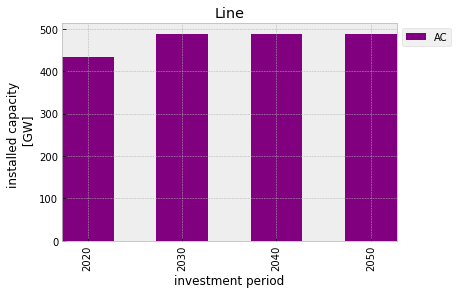

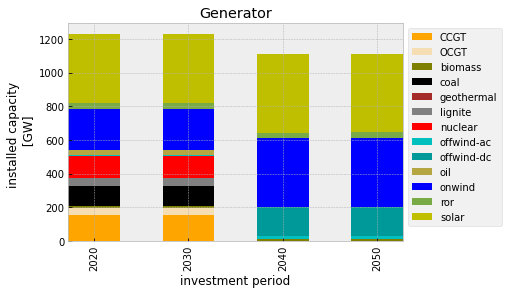

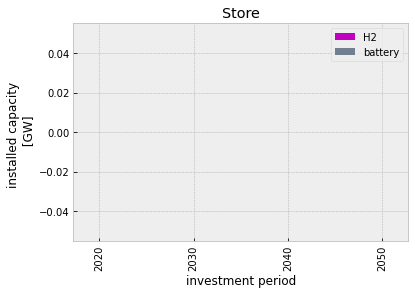

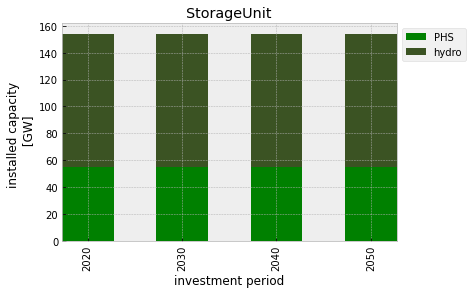

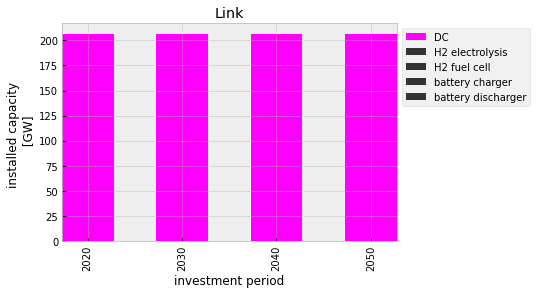

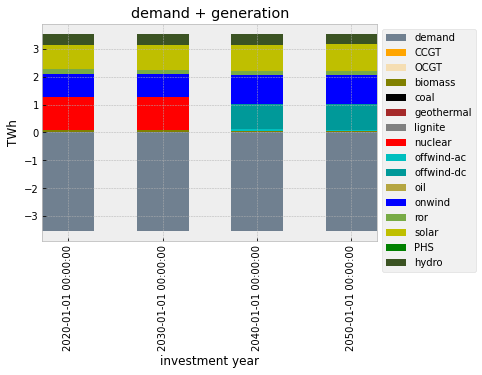

In [59]:
# colormap
with open('/home/ws/bw0928/Dokumente/pypsa-eur-sec/config.yaml', encoding='utf8') as f:
    config = yaml.safe_load(f)
color_map = config["plotting"]['tech_colors']
color_map["biomass"] = "olive"
color_map["geothermal"] = "brown"
color_map["AC"] = "purple"
color_map["DC"] = "magenta"
color_map["demand"] = "slategray"
n.lines["carrier"] = "AC"

# plots
for component in ["Line", "Generator", "Store", "StorageUnit", "Link"]:
    caps = get_cap_per_investment_period(n, component)
    if caps.empty: continue
    caps = caps.groupby(n.df(component)["carrier"], axis=1).sum()/1e3
    ticklabels = caps.index.year
    ax=caps.plot(kind="bar", stacked=True, title=component, grid=True,  width=2000,
                 color=[color_map.get(x, '#333333') for x in caps.columns])
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.ylabel("installed capacity \n [GW]")
    plt.xlabel("investment period")
    plt.legend(bbox_to_anchor=(1,1))

generation = (n.generators_t.p.groupby(n.generators.carrier,axis=1).sum()
              .groupby(level=0).sum())/1e6
demand = (-n.loads_t.p_set.sum(axis=1).groupby(level=0).sum()/1e6)
storage = n.storage_units_t.p.groupby(level=0).sum().groupby(n.storage_units.carrier,axis=1).sum()/1e6
total = pd.concat([demand.rename("demand"), generation, storage],axis=1)
total.plot(kind="bar", stacked=True, title="demand + generation", grid=True,
           width=2000,
                color=[color_map.get(x, '#333333') for x in total.columns]).legend(bbox_to_anchor=(1,1))
plt.ylabel("TWh")
plt.xlabel("investment year")


In [60]:
# check generation covers demand in each investment period
total.sum(axis=1)

investment_period
2020-01-01    4.891254e-12
2030-01-01    4.892253e-12
2040-01-01    4.891809e-12
2050-01-01    4.891643e-12
dtype: float64